<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span><ul class="toc-item"><li><span><a href="#Add-lag-features" data-toc-modified-id="Add-lag-features-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Add lag features</a></span></li></ul></li><li><span><a href="#LigthGBM" data-toc-modified-id="LigthGBM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LigthGBM</a></span></li><li><span><a href="#Predict-for-Kaggle" data-toc-modified-id="Predict-for-Kaggle-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Predict for Kaggle</a></span></li></ul></div>

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import calendar
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

%load_ext autoreload
%autoreload 2

from data_preparation import get_shops, get_item_categories, get_items, prepare_full_dataset, get_duplicate_dict, generate_all_ids_dataset, prepare_zero_dataset, enrich_dataset
from time_series_feats import get_avg_metric, get_lag_metric, calculate_and_add_lag

## Data preparation

In [2]:
train_sales = pd.read_csv('sales_train.csv.zip')
shop_id_map = {0: 57, 1: 58, 10: 11}
train_sales['shop_id'] = train_sales['shop_id'].apply(lambda x: shop_id_map[x] if x in shop_id_map else x)
train_sales['item_cnt_day'] = train_sales['item_cnt_day'].apply(lambda x: x if x > 0 else 0)

In [3]:
item_categories = get_item_categories()
items = get_items(item_categories)

In [4]:
shops = get_shops()

In [5]:
test_df = pd.read_csv('test.csv.zip')

In [6]:
dup_item_dict = get_duplicate_dict(items, test_df)
train_sales['item_id'] = train_sales['item_id'].apply(lambda x: dup_item_dict[x] if x in dup_item_dict else x)

In [7]:
item_ids = items[~items.item_id.isin(dup_item_dict.keys())]['item_id'].unique()
shop_ids = shops[~shops.shop_id.isin([0, 1, 10])]['shop_id'].unique()

In [8]:
train_sales['date'] = train_sales['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))
train_sales['month'] = train_sales['date'].apply(lambda x: x.month)
train_sales['year'] = train_sales['date'].apply(lambda x: x.year)

In [9]:
# emply_values = train_sales[(train_sales.item_id == 2973) & (train_sales.year== 2013) & (train_sales.month == 5) 
#                           # & (train_sales.city == 'Москва')
#                           ]
# item_price_to_impute = emply_values[emply_values.item_price > 0]['item_price'].mean()
# train_sales['item_price'] = train_sales['item_price'].apply(lambda x: x if x > 0 else item_price_to_impute)

In [9]:
baseline_train = train_sales[train_sales.item_price > 0].groupby( ['date_block_num', 'shop_id',  'item_id', 'month', 'year']).agg(
    {'item_cnt_day': 'sum', 'item_price':'mean'}).reset_index()
baseline_train = baseline_train.rename(columns={'item_cnt_day':'item_cnt_month'})

In [10]:
%%time
all_ids_dataset = generate_all_ids_dataset(2013, 1, 2015, 10, item_ids, shop_ids)

Wall time: 6min 36s


In [11]:
%%time
block_num_df = baseline_train[['date_block_num', 'month', 'year']].drop_duplicates()
all_ids_dataset = all_ids_dataset.merge(block_num_df, how='left', on=['month', 'year'])

Wall time: 22.4 s


In [12]:
all_ids_dataset.drop(columns=['date'], inplace=True)

In [13]:
%%time
train_with_zeroes = all_ids_dataset.merge(baseline_train, 
                 how='left', on=[ 'shop_id', 'item_id', 'month', 'year', 'date_block_num' ])

Wall time: 47.2 s


In [14]:
train_with_zeroes.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42851118 entries, 0 to 42851117
Data columns (total 7 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   item_id         42851118 non-null  object 
 1   shop_id         42851118 non-null  object 
 2   year            42851118 non-null  int64  
 3   month           42851118 non-null  int64  
 4   date_block_num  42851118 non-null  int64  
 5   item_cnt_month  1607604 non-null   float64
 6   item_price      1607604 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.6+ GB


In [15]:
train_with_zeroes.sort_values(by='date_block_num', inplace=True)
train_with_zeroes['item_price'] = train_with_zeroes.groupby(['item_id', 'shop_id'])['item_price'].ffill().bfill()
train_with_zeroes['item_price'] = train_with_zeroes.groupby(['item_id'])['item_price'].ffill().bfill()

In [16]:
train_with_zeroes.fillna(0, inplace=True)

In [17]:
train_with_zeroes['item_id'] = train_with_zeroes['item_id'].astype(np.int64)
train_with_zeroes['shop_id'] = train_with_zeroes['shop_id'].astype(np.int64)
train_with_zeroes['item_cnt_month'] = train_with_zeroes['item_cnt_month'].astype(np.int64)

In [18]:
%%time
full_train = enrich_dataset(train_with_zeroes, items, shops)

Wall time: 1min 10s


In [19]:
full_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42851118 entries, 0 to 42851117
Data columns (total 12 columns):
 #   Column            Non-Null Count     Dtype  
---  ------            --------------     -----  
 0   item_id           42851118 non-null  int64  
 1   shop_id           42851118 non-null  int64  
 2   year              42851118 non-null  int64  
 3   month             42851118 non-null  int64  
 4   date_block_num    42851118 non-null  int64  
 5   item_cnt_month    42851118 non-null  int64  
 6   item_price        42851118 non-null  float64
 7   shop_type         42851118 non-null  object 
 8   city              42851118 non-null  object 
 9   item_category_id  42851118 non-null  int64  
 10  category          42851118 non-null  object 
 11  sub_category      42851118 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 4.2+ GB


In [20]:
category_encoder = LabelEncoder()
full_train['category_code'] = category_encoder.fit_transform(full_train['category'])
#test_df['category_code'] = category_encoder.transform(test_df['category'])

sub_category_encoder = LabelEncoder()
full_train['sub_category_code'] = sub_category_encoder.fit_transform(full_train['sub_category'])
#test_df['sub_category_code'] = sub_category_encoder.transform(test_df['sub_category'])

# city_encoder = LabelEncoder()
# full_train['city_code'] = city_encoder.fit_transform(full_train['city'])
#test_df['city_code'] = city_encoder.transform(test_df['city'])

shop_encoder = LabelEncoder()
full_train['shop_type_code'] = shop_encoder.fit_transform(full_train['shop_type'])
#test_df['shop_type_code'] = shop_encoder.transform(test_df['shop_type'])

In [21]:
full_train.drop(columns=['category', 'sub_category', 'city', 'shop_type'], inplace=True)

In [22]:
real_train = full_train[full_train.date_block_num > 11]

In [23]:
def enrich_real_train(full_df, real_df, cols, date_block=None):
    group_by_cols, group_cols = calculate_and_add_lag(full_df, cols, date_block)
    real_df = pd.merge(real_df, group_by_cols, on=group_cols, how='left')
    return real_df

### Add lag features

In [24]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'item_id'])

Wall time: 29.7 s


In [25]:
%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id'])

Wall time: 0 ns


In [26]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'item_id'])

Wall time: 18min 13s


In [27]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num',  'item_category_id'])

Wall time: 2min 10s


In [28]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'category_code'])

Wall time: 2min 33s


In [29]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'sub_category_code'])

Wall time: 3min 12s


In [30]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'category_code'])

Wall time: 3min 50s


In [31]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'sub_category_code'])

MemoryError: Unable to allocate 3.72 GiB for an array with shape (18, 27727194) and data type float64

In [32]:
%%time
real_train = enrich_real_train(full_train, real_train, ['date_block_num', 'shop_id', 'item_category_id'])

MemoryError: Unable to allocate 327. MiB for an array with shape (42851118,) and data type int64

In [33]:
del full_train

In [34]:
real_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27727194 entries, 0 to 27727193
Data columns (total 137 columns):
 #    Column                                     Non-Null Count     Dtype  
---   ------                                     --------------     -----  
 0    item_id                                    27727194 non-null  int64  
 1    shop_id                                    27727194 non-null  int64  
 2    year                                       27727194 non-null  int64  
 3    month                                      27727194 non-null  int64  
 4    date_block_num                             27727194 non-null  int64  
 5    item_cnt_month                             27727194 non-null  int64  
 6    item_price                                 27727194 non-null  float64
 7    item_category_id                           27727194 non-null  int64  
 8    category_code                              27727194 non-null  int32  
 9    sub_category_code                         

In [48]:

# %%time
# full_train_with_zeroes = calculate_and_add_lag(full_train_with_zeroes, ['date_block_num', 'shop_id', 'sub_category'])

In [49]:
# %%time
# full_train_with_zeroes = calculate_and_add_lag(full_train_with_zeroes, ['date_block_num', 'sub_category'])

In [50]:
# %%time
# full_train_with_zeroes = calculate_and_add_lag(full_train_with_zeroes, ['date_block_num', 'category'])

In [100]:
#real_train['before_ny'] = real_train['month'].apply(lambda x: int(x == 12))

In [38]:
#real_train.drop(columns= ['category_code'], inplace=True)

In [75]:
real_train.columns.values

array(['item_id', 'shop_id', 'year', 'month', 'date_block_num',
       'item_cnt_month', 'item_price', 'item_category_id',
       'category_code', 'sub_category_code', 'shop_type_code',
       'item_id_avg_item_cnt_lag_1', 'item_id_avg_item_cnt_lag_2',
       'item_id_avg_item_cnt_lag_3', 'item_id_avg_item_cnt_lag_6',
       'item_id_avg_item_cnt_lag_9', 'item_id_avg_item_cnt_lag_12',
       'shop_id_avg_item_cnt_lag_1', 'shop_id_avg_item_cnt_lag_2',
       'shop_id_avg_item_cnt_lag_3', 'shop_id_avg_item_cnt_lag_6',
       'shop_id_avg_item_cnt_lag_9', 'shop_id_avg_item_cnt_lag_12',
       'shop_id_item_id_avg_item_cnt_lag_1',
       'shop_id_item_id_avg_item_cnt_lag_2',
       'shop_id_item_id_avg_item_cnt_lag_3',
       'shop_id_item_id_avg_item_cnt_lag_6',
       'shop_id_item_id_avg_item_cnt_lag_9',
       'shop_id_item_id_avg_item_cnt_lag_12',
       'item_category_id_avg_item_cnt_lag_1',
       'item_category_id_avg_item_cnt_lag_2',
       'item_category_id_avg_item_cnt_lag_3',
 

## LigthGBM

In [35]:
y = real_train['item_cnt_month']
real_train.drop(columns= ['item_cnt_month'], inplace=True)
X = real_train

MemoryError: Unable to allocate 26.2 GiB for an array with shape (127, 27727194) and data type float64

In [41]:
def cross_val_ts(df_x, df_y, date_block_start, model):
    scores = []
    for i in range(date_block_start, 34):
        start = time.time()
        X_train = df_x[df_x.date_block_num < i]
        y_train = df_y[df_x.date_block_num < i]
        
        X_test = df_x[df_x.date_block_num == i]
        y_test = df_y[df_x.date_block_num == i]
        
        model.fit(df_x[df_x.date_block_num < i], df_y[df_x.date_block_num < i])
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred, squared=False)
        scores.append(score)
        end = time.time()
        print(f"{i} date_block_num: score {score}  time: {end - start}")
        
    return scores

In [77]:
lgbm = LGBMRegressor()

In [ ]:
%%time



cv_score = cross_val_ts(X, y, 19, lgbm)


19 date_block_num: score 0.6388742357575786  time: -153.13765573501587
20 date_block_num: score 1.4679876827556502  time: -137.64365696907043
21 date_block_num: score 1.5132306844992598  time: -158.6067442893982
22 date_block_num: score 1.5343898812514205  time: -182.42539310455322
23 date_block_num: score 1.4845915846686746  time: -192.40467834472656
24 date_block_num: score 1.6480268198418744  time: -205.9372627735138
25 date_block_num: score 1.2792427959848556  time: -229.5519254207611
26 date_block_num: score 0.9216596168015576  time: -333.3990831375122
27 date_block_num: score 1.980171369565211  time: -273.1559910774231


In [78]:
lgbm.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [40]:
np.mean(cv_score)

1.3348255725664147

In [102]:
X.head(1)


,item_id,shop_id,year,month,date_block_num,item_price,item_category_id,category_code,sub_category_code,shop_type_code,...,shop_id_sub_category_code_avg_item_cnt_lag_3,shop_id_sub_category_code_avg_item_cnt_lag_6,shop_id_sub_category_code_avg_item_cnt_lag_9,shop_id_sub_category_code_avg_item_cnt_lag_12,shop_id_item_category_id_avg_item_cnt_lag_1,shop_id_item_category_id_avg_item_cnt_lag_2,shop_id_item_category_id_avg_item_cnt_lag_3,shop_id_item_category_id_avg_item_cnt_lag_6,shop_id_item_category_id_avg_item_cnt_lag_9,shop_id_item_category_id_avg_item_cnt_lag_12
0,0,2,2014,1,12,28.0,40,11,6,4,...,0.012314,0.013174,0.012954,0.014399,0.018471,0.014101,0.012314,0.013174,0.012954,0.014399


In [79]:
useful_cols = ['item_id', 'shop_id', 'year', 'month', 'date_block_num',
       'item_cnt_month', 'item_price', 'item_category_id', 'category_code',
       'sub_category_code', 'shop_type_code']
drop_cols = [x for x in X.columns.values if x not in useful_cols]

In [80]:
real_train.drop(columns=drop_cols, inplace=True)

## Predict for Kaggle

In [88]:
test_df['year'] = 2015
test_df['month'] = 11
test_df['date_block_num'] = 34
test_df['item_price'] = float('nan')
test_df['item_cnt_month'] = 0

In [89]:
test_df = enrich_dataset(test_df, items, shops)

In [90]:
test_df['category_code'] = category_encoder.transform(test_df['category'])
test_df['sub_category_code'] = sub_category_encoder.transform(test_df['sub_category'])
#test_df['city_code'] = city_encoder.transform(test_df['city'])
test_df['shop_type_code'] = shop_encoder.transform(test_df['shop_type'])
#test_df['before_ny'] = test_df['month'].apply(lambda x: int(x == 12))

In [91]:
id_mapping = test_df[['ID', 'shop_id', 'item_id']].drop_duplicates()

In [92]:
test_df.drop(columns=['category', 'sub_category', 'city', 'shop_type', 'ID'], inplace=True)

In [93]:
real_train_with_y = pd.concat([real_train, y], axis=1)

In [94]:
del real_train

In [95]:
real_train_with_y.head(5)

,item_id,shop_id,year,month,date_block_num,item_price,item_category_id,category_code,sub_category_code,shop_type_code,item_cnt_month
0,0,2,2014,1,12,28.0,40,11,6,4,0
1,0,2,2014,2,13,28.0,40,11,6,4,0
2,0,2,2014,3,14,28.0,40,11,6,4,0
3,0,2,2014,4,15,28.0,40,11,6,4,0
4,0,2,2014,5,16,28.0,40,11,6,4,0


In [96]:
test_df.head()

,shop_id,item_id,year,month,date_block_num,item_price,item_cnt_month,item_category_id,category_code,sub_category_code,shop_type_code
0,5,5037,2015,11,34,NaN,0,19,5,12,3
1,4,5037,2015,11,34,NaN,0,19,5,12,4
2,6,5037,2015,11,34,NaN,0,19,5,12,0
3,3,5037,2015,11,34,NaN,0,19,5,12,2
4,2,5037,2015,11,34,NaN,0,19,5,12,4


In [97]:
test_df = pd.concat([real_train_with_y, test_df])
test_df.sort_values(by=['date_block_num'], inplace=True)

In [98]:
test_df['item_price'] = test_df.groupby(['item_id', 'shop_id'])['item_price'].ffill().bfill()
test_df['item_price'] = test_df.groupby(['item_id'])['item_price'].ffill().bfill()

In [99]:
test_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27941394 entries, 0 to 214199
Data columns (total 11 columns):
 #   Column             Non-Null Count     Dtype  
---  ------             --------------     -----  
 0   item_id            27941394 non-null  int64  
 1   shop_id            27941394 non-null  int64  
 2   year               27941394 non-null  int64  
 3   month              27941394 non-null  int64  
 4   date_block_num     27941394 non-null  int64  
 5   item_price         27941394 non-null  float64
 6   item_category_id   27941394 non-null  int64  
 7   category_code      27941394 non-null  int32  
 8   sub_category_code  27941394 non-null  int32  
 9   shop_type_code     27941394 non-null  int32  
 10  item_cnt_month     27941394 non-null  int64  
dtypes: float64(1), int32(3), int64(7)
memory usage: 2.2 GB


In [100]:
real_test = test_df[test_df.date_block_num == 34]

In [101]:
real_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 142795 to 214199
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   item_id            214200 non-null  int64  
 1   shop_id            214200 non-null  int64  
 2   year               214200 non-null  int64  
 3   month              214200 non-null  int64  
 4   date_block_num     214200 non-null  int64  
 5   item_price         214200 non-null  float64
 6   item_category_id   214200 non-null  int64  
 7   category_code      214200 non-null  int32  
 8   sub_category_code  214200 non-null  int32  
 9   shop_type_code     214200 non-null  int32  
 10  item_cnt_month     214200 non-null  int64  
dtypes: float64(1), int32(3), int64(7)
memory usage: 17.2 MB


In [102]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'item_id'], 34)

Wall time: 7.38 s


In [103]:
%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'shop_id'], 34)

Wall time: 0 ns


In [104]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'shop_id', 'item_id'], 34)

Wall time: 59.1 s


In [105]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num',  'item_category_id'], 34)

Wall time: 2.89 s


In [106]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'category_code'], 34)

Wall time: 3.21 s


In [107]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'sub_category_code'], 34)

Wall time: 3.21 s


In [108]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'shop_id', 'category_code'])

Wall time: 5.57 s


In [109]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'shop_id', 'sub_category_code'])

Wall time: 6.52 s


In [110]:
%%time
real_test = enrich_real_train(test_df, real_test, ['date_block_num', 'shop_id', 'item_category_id'])

Wall time: 6.19 s


In [111]:
real_test.fillna(0, inplace=True)

In [68]:
#real_test.drop(columns= ['category_code'], inplace=True)

In [112]:
X_test = real_test.drop(columns = ['item_cnt_month'])

In [113]:
X_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 64 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   item_id                                        214200 non-null  int64  
 1   shop_id                                        214200 non-null  int64  
 2   year                                           214200 non-null  int64  
 3   month                                          214200 non-null  int64  
 4   date_block_num                                 214200 non-null  int64  
 5   item_price                                     214200 non-null  float64
 6   item_category_id                               214200 non-null  int64  
 7   category_code                                  214200 non-null  int32  
 8   sub_category_code                              214200 non-null  int32  
 9   shop_type_code                       

In [114]:
y_pred = lgbm.predict(X_test)

In [115]:
result_df = X_test[['shop_id', 'item_id']]

In [116]:
result_df['item_cnt_month'] = y_pred

In [117]:
result_df.head()

,shop_id,item_id,item_cnt_month
0,46,15624,0.008502
1,41,15624,0.006882
2,44,15624,0.006882
3,34,15624,0.004897
4,38,15624,0.004897


In [118]:
final_result = id_mapping.merge(result_df, on=['shop_id', 'item_id'], how='left')

In [119]:
final_result.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   shop_id         214200 non-null  int64  
 2   item_id         214200 non-null  int64  
 3   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 8.2 MB


In [120]:
def save_prediction(predicted_df, filename):
    subm = pd.read_csv('sample_submission.csv.zip')[['ID']]
    res = subm.merge(predicted_df, on='ID', how='left')
    res = res.drop(columns=['item_id', 'shop_id'])
    res.to_csv(filename, index=False)
    return res

In [121]:
save_prediction(final_result, 'lgbm_result_2.csv')

,ID,item_cnt_month
0,0,0.529835
1,1,0.014787
2,2,0.914247
3,3,0.330476
4,4,0.100570
...,...,...
214195,214195,0.112617
214196,214196,0.012124
214197,214197,0.034755
214198,214198,0.005463


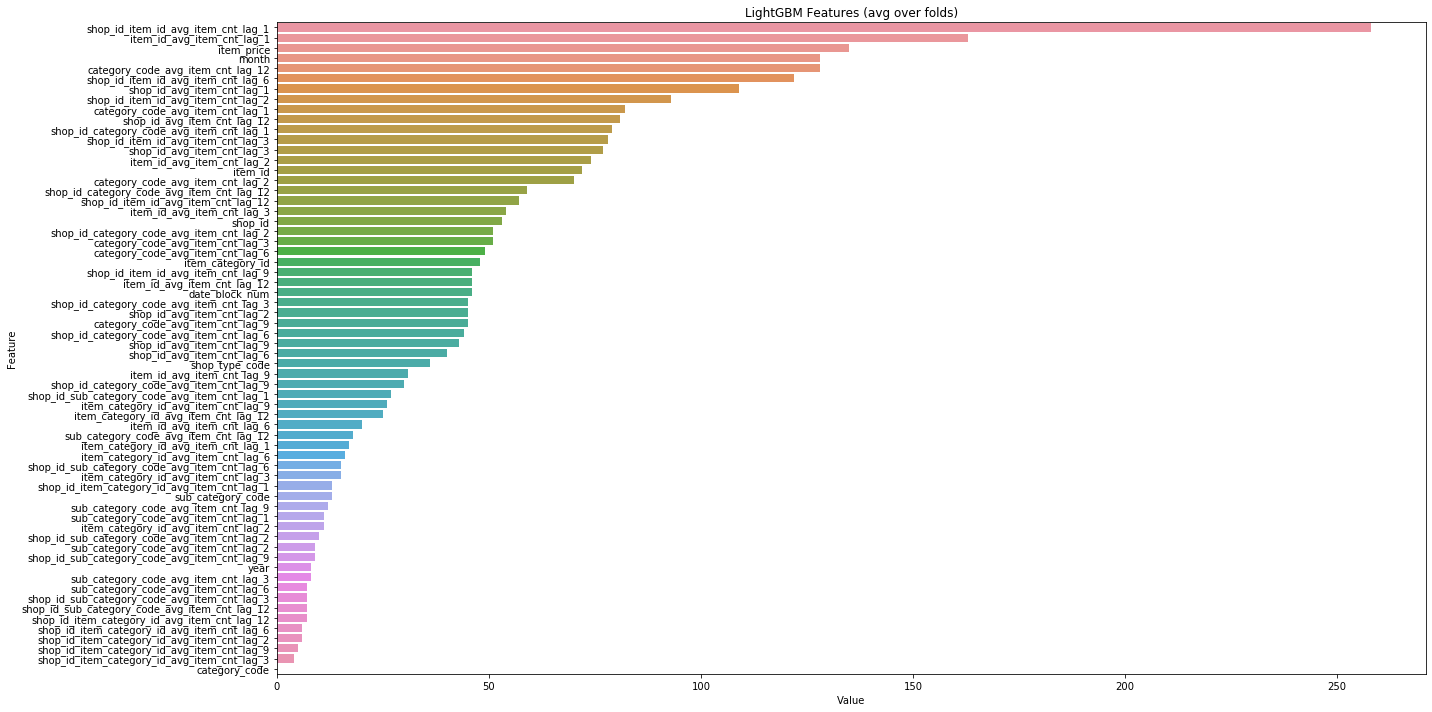

<Figure size 432x288 with 0 Axes>

In [122]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')